In [2]:
from classiq import *
from classiq.execution import ExecutionPreferences
import numpy as np

# Quantum Random Walk on a Line with 16 Nodes

We adapt the algorithm for the random walk on the 4 node circle from the lecture for a line with 16 nodes, shown below. 

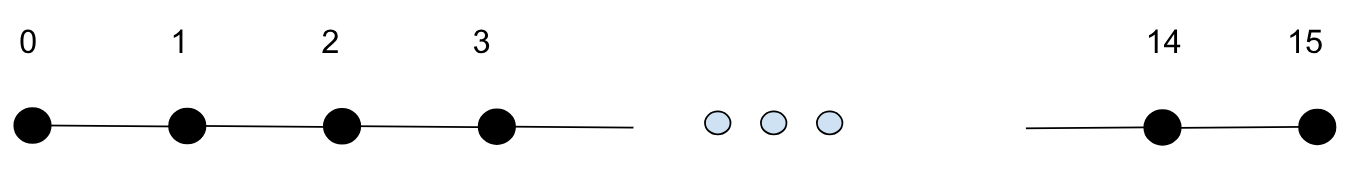

While the overall algorithm remains the same, some components are graph dependent, and therefore must be modified. This includes the W operator (and W iterator), as well as the edge oracle function. 

The W operator code implements the function 
$$
C := \sum_{j \in V} |j\rangle \langle j| \otimes (2 |\delta_j \rangle \langle delta_j | - I)
$$
where j is a vertex in the set of vertices V. Here, the operator is only applied if one is in state j.

Here, since we have a straight line, we know that at the ends, i.e., $j = 1$ or $j = 16$ (or 0 and 15 respectively in the code), the probability in the random walk to move to an adjacent node is 1, while on any of the center nodes, there is a 0.5 probability to move either right or left. This is implemented in the *W_iterator* function. 

The edge oracle is modified as well. In the edge oracle, we return a 1 only if the two vertices defined in the function are adjacent to each other. For a straight line graph, this is only possible if the difference between the two vertices specified is 1. The edge oracle is useful for the S operator, which is defined as 
$$
S := \sum_{(j, k) \in E} | j, k \rangle \langle k, j |
$$
where the pair (j, k) defines an edge in the set of edges E, specifying that the two vertices are next to each other. 

In [16]:
# 16 nodes so we use 4 qubits (2^4 = 16)

size = 4

@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux), action=lambda: diffuzer_oracle)


In [17]:
nodes = 16

def W_iteration(i : int, vertices : QNum, adjacent_vertices : QNum):
    # prob = np.zeros((nodes,), dtype=int)
    prob = [0 for i in range (nodes)]
    if i == 0:
       prob [i + 1] = 1
    elif i == (nodes - 1):
       prob [i - 1] = 1
    else: 
      prob [i + 1] = 0.5
      prob [i - 1] = 0.5
    print(f'State={i}, prob vec ={prob}')
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(nodes):
      W_iteration(i, vertices, adjacent_vertices)

@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  # diff = np.abs(vertices - adjacent_vertices) #abs/np.abs does not work?
  diff = vertices - adjacent_vertices
  res |= ((diff == 1) | (diff == -1))

@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))

In [18]:
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl= res==1,
        operand = lambda: bitwise_swap(vertices, adjacent_vertices))

In [19]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size, vertices)
  hadamard_transform(vertices)
  allocate(size, adjacent_vertices)

  W_operator(vertices, adjacent_vertices)
  S_operator(vertices, adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 

/usr/bin/xdg-open: 882: x-www-browser: not found
/usr/bin/xdg-open: 882: firefox: not found
/usr/bin/xdg-open: 882: iceweasel: not found
/usr/bin/xdg-open: 882: seamonkey: not found
/usr/bin/xdg-open: 882: mozilla: not found
/usr/bin/xdg-open: 882: epiphany: not found
/usr/bin/xdg-open: 882: konqueror: not found
/usr/bin/xdg-open: 882: chromium: not found
/usr/bin/xdg-open: 882: chromium-browser: not found
/usr/bin/xdg-open: 882: google-chrome: not found
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'https://platform.classiq.io/circuit/0bcb34b3-2356-4b53-90a7-b78f52c47d93?version=0.43.3'


The following image is the synthesized circuit, in which we can see a visualization of how the circuit and the functions are being implemented. We use the Hadamard gate in the beginning to create an equal superposition of the states, after which the W operator is applied to each qubit, and then the edge oracle is applied to each of the states, in which there occurs a bitwise swap if the number *vertices* and *adjacent_vertices* are separated only by one, implying that the vertices are next to each other.

![hw4 circuit.jpg](<attachment:hw4 circuit.jpg>)
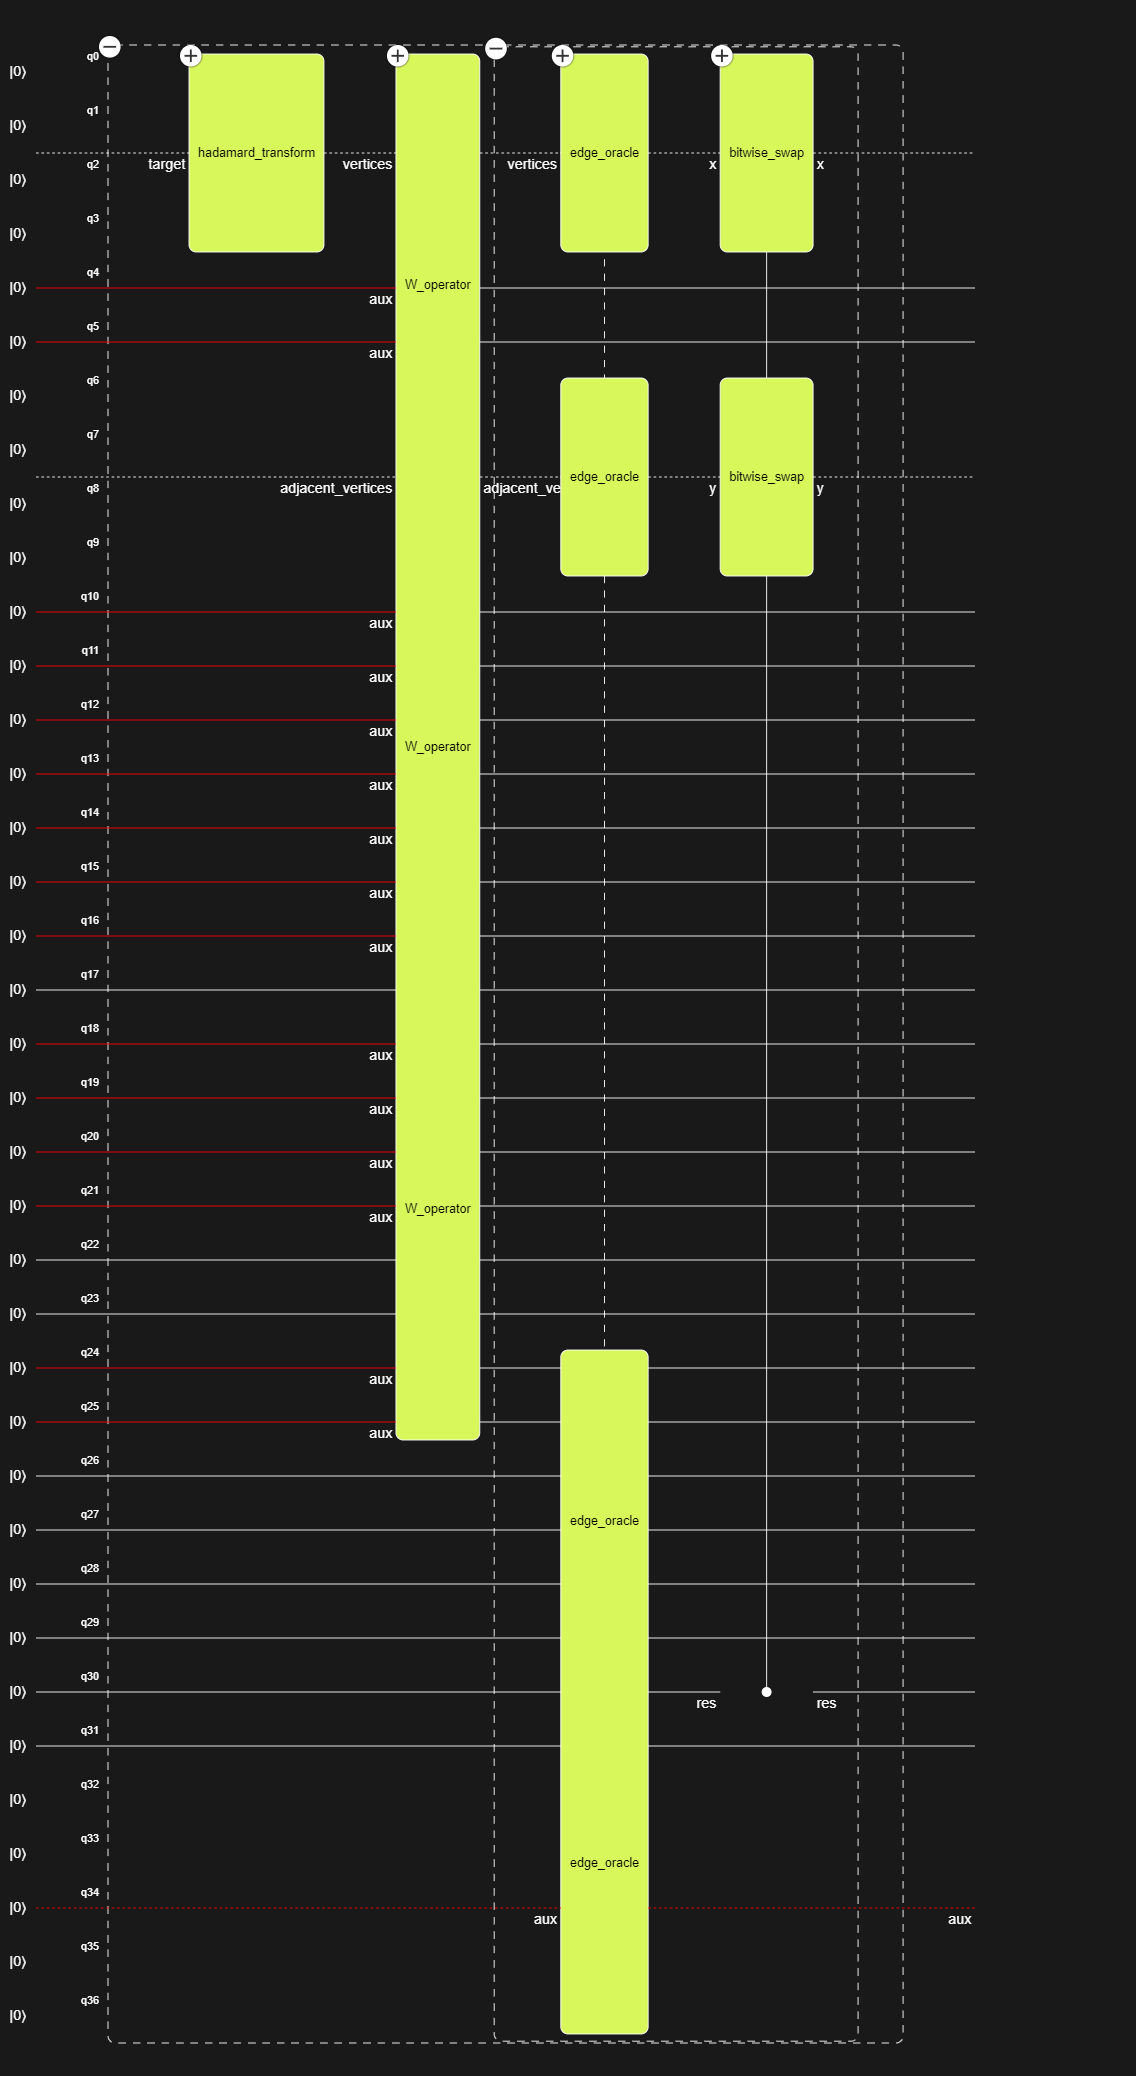